## Composite, non-linear rheology:


The viscous rheology in this model is similar to the Garel et al paper cited below. Other parts of the model setup are similar to Čížková and Bina (2015), Arredondo and Billen (2016) and Korenaga (2011). 

Here we use a dimensionless system. For the psuedo-plastic effective rheology a Drucker-prager model is used.


**Keywords:** subduction, composite rheology, dislocation creep


**References:**


Garel, Fanny, et al. "Interaction of subducted slabs with the mantle transition‐zone: A regime diagram from 2‐D thermo‐mechanical models with a mobile trench and an overriding plate." Geochemistry, Geophysics, Geosystems 15.5 (2014): 1739-1765.

Čížková, Hana, and Craig R. Bina. "Geodynamics of trench advance: Insights from a Philippine-Sea-style geometry." Earth and Planetary Science Letters 430 (2015): 408-415.

Arredondo, Katrina M., and Magali I. Billen. "The Effects of Phase Transitions and Compositional Layering in Two-dimensional Kinematic Models of Subduction." Journal of Geodynamics (2016).

Korenaga, Jun. "Scaling of plate tectonic convection with pseudoplastic rheology." Journal of Geophysical Research: Solid Earth 115.B11 (2010).

In [1]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import operator
import pint
import time
import operator
from slippy2 import boundary_layer2d
from slippy2 import material_graph
from slippy2 import spmesh
from slippy2 import phase_function

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [2]:
#store = glucifer.Store('subduction')
#figParticle = glucifer.Figure( store, figsize=(960,300), name="Particles" )

#figParticle.save_database('test.gldb')

Model name and directories
-----

In [3]:
############
#Model name.  
############
Model = "T"
ModNum = 0

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])

In [4]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" + str(ModIt) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [5]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False

results/T/0/Base/checkpoint/ is empty


Setup parameters
-----

Set simulation parameters for test.

**Use pint to setup any unit conversions we'll need**

In [6]:
u = pint.UnitRegistry()
cmpery = 1.*u.cm/u.year
mpermy = 1.*u.m/u.megayear
year = 1.*u.year
spery = year.to(u.sec)
cmpery.to(mpermy)

<Quantity(10000.0, 'meter / megayear')>

In [7]:
box_half_width =4000e3
age_at_trench = 100e6
cmperyear = box_half_width / age_at_trench #m/y
mpersec = cmperyear*(cmpery.to(u.m/u.second)).magnitude #m/sec
print(cmperyear, mpersec )

(0.04, 1.2675505856327397e-11)


**Model flags**

In [8]:
#Modelling and Physics switches
refineMesh = True
stickyAir = False 
meltViscosityReduction = False
symmetricIC = False
sticky_air_temp = 5
eba = False  #Flag for extended boussinesq
pressure_correct = False

**Set parameter dictionaries**

In [67]:
###########
#Store the physical parameters, scale factors and dimensionless pramters in easyDicts
#Mainly helps with avoiding overwriting variables
###########


#Style => parameters_like_this

dp = edict({'depth':0.5*2900.*1e3, #Depth
            'LS':2900.*1e3, #Length scale
           'rho':3300.,  #reference density
           'g':9.8, #surface gravity
           'eta0':1e20, #Dislocation creep at 250 km, 1573 K, 1e-15 s-1 
           'k':1e-6, #thermal diffusivity
           'a':3e-5, #surface thermal expansivity
           'TP':1573., #mantle potential temp (K)
           'TS':273., #surface temp (K)
           'cohesion':2e6, #cohesion in Byerlee law
           'fc':0.2,   #friction coefficient in Byerlee law (tan(phi))
           'Adf':3e-11, #pre-exp factor for diffusion creep
           'Ads':5e-16, #pre-exp factor for dislocation creep
           'Apr':1e-150,#pre-exp factor for Peierls creep
           'Edf':3e5,
           'Eds':5.4e5,
           'Epr':5.4e5,
           'Vdf':4e-6,
           'Vds':12e-6,
           'Vpr':10e-6,
           'Alm':2e-16,
           'Elm':2.0e5,
           'Vlm':1.5e-6,
           'Ba':4.3e-12,  #A value to simulate pressure increase with depth
            'BAdT':0.0005, #adiabatic temp gradient used to correct rheology if Boussinesq approx.
           'SR':1e-15,
           #'Dr':250e3, #Reference depth
           'rDepth':250e3, #reference depth (used to scale / normalize the flow laws)
           'R':8.314, #gas constant
           'Cp':1250., #Specific heat (Jkg-1K-1)
           'StALS':100e3, #depth of sticky air layer
           'plate_vel':4})

#Adiabatic heating stuff
if eba:
    dp.dTa = (dp.a*dp.g*(dp.TP))/dp.Cp #adibatic gradient, at Tp
else:
    dp.dTa = 0.    
dp.deltaTa = (dp.TP + dp.dTa*dp.LS) - dp.TS  #Adiabatic Temp at base of mantle, minus Ts
dp.rTemp= dp.TP + dp.rDepth*dp.dTa #reference temp, (potential temp + adiabat)


#scale_factors

sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
            'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) ,
            'vel':dp.LS/dp.k,
            'SR':dp.LS**2/dp.k,
            'W':(-1./dp.Ba)*(np.log(1.-dp.rho*dp.g*dp.Ba*dp.LS))/(dp.R*dp.deltaTa), #Including adiabatic compression, and deltaTa
            'E': 1./(dp.R*dp.deltaTa), #using deltaTa, the guesstimated adiabatic temp differnnce to scale these paramters
            #'Ads':(dp.eta0**(ndp.n-2))*((dp.k)**(ndp.n-1))*((dp.LS)**(2. - 2*ndp.n))       
           })

#dimensionless parameters

ndp = edict({'RA':(dp.g*dp.rho*dp.a*dp.deltaTa*(dp.LS)**3)/(dp.k*dp.eta0),
            'cohesion':dp.cohesion*sf.stress,
            'fcd':dp.fc*sf.lith_grad,
            'gamma':dp.fc/(dp.a*dp.deltaTa),
            'Wdf':dp.Vdf*sf.W,
            'Edf':dp.Edf*sf.E,
            'Wps':dp.Vpr*sf.W,
            'Eps':dp.Epr*sf.E,
            'Wds':dp.Vds*sf.W,
            'Eds':dp.Eds*sf.E,
            'Elm':dp.Elm*sf.E,
            'Elm':dp.Elm*sf.E,
            'Wlm':dp.Vlm*sf.W,
            'TSP':0., 
            'TBP':1.,
            'TPP':(dp.TP - dp.TS)/dp.deltaTa, #dimensionless potential temp
            'rDepth':dp.rDepth/dp.LS,
            'rTemp':(dp.rTemp- dp.TS)/dp.deltaTa,
            'n':3.5, #Dislocation creep stress exponent
            'np':20., #Peierls creep stress exponent
            'TS':dp.TS/dp.deltaTa,
            'TP':dp.TP/dp.deltaTa,
            'eta_min':1e-3, 
            'eta_max':1e5, #viscosity max in the mantle material
            'eta_max_crust':0.5, #viscosity max in the weak-crust material
            'H':0.,
            'Tmvp':0.6,
            'Di': dp.a*dp.g*dp.LS/dp.Cp, #Dissipation number
            'Steta0':1e2,
            'plate_vel':sf.vel*dp.plate_vel*(cmpery.to(u.m/u.second)).magnitude,
            'low_mantle_visc_fac':1.,
            'crust_cohesion_fac':1.,
            'crust_fc_fac':0.01})

#Make some further additions to paramter dictionaries

#dp.VR = (0.1*(dp.k/dp.LS)*ndp.RA**(2/3.)) #characteristic velocity from a scaling relationship
#dp.SR = dp.VR/dp.LS #characteristic strain rate
#ndp.VR = dp.VR*sf.vel #characteristic velocity
#ndp.SR = dp.SR*sf.SR #characteristic strain rate


ndp.SR = dp.SR*sf.SR #characteristic strain rate

ndp.StRA = (3300.*dp.g*(dp.LS)**3)/(dp.eta0 *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
ndp.TaP = 1. - ndp.TPP,  #Dimensionles adiabtic component of deltaT

In [68]:
dp.LS

2900000.0

In [11]:
###########
#lengths scales for various processes (material transistions etc.)
###########

MANTLETOCRUST = (20.*1e3)/dp.LS #Crust depth
HARZBURGDEPTH = MANTLETOCRUST + (27.7e3/dp.LS)
CRUSTTOMANTLE = (800.*1e3)/dp.LS
LITHTOMANTLE = (900.*1e3)/dp.LS 
MANTLETOLITH = (200.*1e3)/dp.LS 
TOPOHEIGHT = (10.*1e3)/dp.LS  #rock-air topography limits
CRUSTTOECL  = (100.*1e3)/dp.LS
AVGTEMP = ndp.TPP #Used to define lithosphere
LOWMANTLEDEPTH = (660.*1e3)/dp.LS 
CRUSTVISCUTOFF = (150.*1e3)/dp.LS #Deeper than this, crust material rheology reverts to mantle rheology
AGETRACKDEPTH = 100e3/dp.LS #above this depth we track the age of the lithsphere (below age is assumed zero)


**Model/ mesh  setup parameters**

In [12]:
###########
#Model setup parameters
###########

compBuoyancy = False #use compositional & phase buoyancy, or simply thermal
viscMechs = ['diffusion', 'dislocation', 'peierls', 'yielding']
viscCombine = 'harmonic' #'harmonic', 'min', 'mixed'....

#Domain and Mesh paramters

RES = 64

VelBC = False
if dp.depth == 2900.e3:
    aspectRatio = 10000e3/dp.depth
    Xres = RES*4
elif dp.depth == 0.5*2900.e3:
    aspectRatio = 10000e3/dp.depth
    Xres = RES*8
else:
    print ("depth should be 2900km, or 1450 km")

dim = 2          # number of spatial dimensions
hw = np.round(5000e3/dp.LS, 1)
MINX = -1*hw
MINY = 1. - (dp.depth/dp.LS)


MAXX = hw
MAXY = 1.


if stickyAir:
    Yres = RES
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = RES
    MAXY = 1.

periodic = [False, False]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"


#System/Solver stuff
PIC_integration=True
ppc = 25

#Metric output stuff
figures =  'gldb' #glucifer Store won't work on all machines, if not, set to 'gldb' 
swarm_repop, swarm_update = 10, 10
gldbs_output = 6
checkpoint_every, files_output = 6, 2 #checkpoint every needs to be greater or equal to metric_output 
metric_output = 6


In [13]:
dp.dTa

0.0

Create mesh and finite element variables
------

In [14]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX, MINY), 
                                 maxCoord    = (MAXX, MAXY), periodic=periodic)

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [15]:
mesh.reset()


In [16]:
###########
#Mesh refinement
###########

#X-Axis

if refineMesh:
    mesh.reset()
    axis = 0
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (abs(mesh.maxCoord[axis]) - abs(mesh.minCoord[axis]))/2.
    el_reduction = 0.51
    dx = mesh.maxCoord[axis] - min_point

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction) *deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'x',norm = 'Min', constraints = [])

Min
(512, 0.0033867187499999774, 2.5840000000000054, 0.95999999999997443)
('edges', 512)
-- iteration 0 --
| F( p_n ) |^2: 2.1341247797e-05
| p_n+1 - p_n |^2: 11.8441792803
-- iteration 1 --
| F( p_n ) |^2: 4.40508176067e-30
Min, Max element width: 
0.00339
0.00989


In [17]:
axis = 1
orgs = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)

value_to_constrain = 1.


yconst = [(spmesh.find_closest(orgs, value_to_constrain), np.array([value_to_constrain,0]))]

In [18]:
###########
#Mesh refinement
###########

if refineMesh:
    #Y-Axis
    axis = 1
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (mesh.maxCoord[axis])
    el_reduction = 0.5
    dx = mesh.maxCoord[axis]

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction)*deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'y',norm = 'Min', constraints = yconst)

Min
(64, 0.00390625, 0.3115234375, 3.0634920634920637)
('edges', 64)
-- iteration 0 --
| F( p_n ) |^2: 3.1486390129e-05
| p_n+1 - p_n |^2: 0.137599723049
-- iteration 1 --
| F( p_n ) |^2: 3.42851641287e-31
Min, Max element width: 
0.00391
0.01172


In [19]:
#fig= glucifer.Figure()
#fig.append(glucifer.objects.Mesh(mesh))

#fig.show()
#fig.save_database('test.gldb')

Initial conditions
-------


In [20]:
coordinate = fn.input()
depthFn = 1. - coordinate[1] #a function providing the depth
xFn = coordinate[0]  #a function providing the x-coordinate
yFn = coordinate[1]  #a function providing the y-coordinate

potTempFn = ndp.TPP + (depthFn)*ndp.TaP #a function providing the adiabatic temp at any depth
abHeatFn = -1.*velocityField[1]*temperatureField*ndp.Di #a function providing the adiabatic heating rate

In [21]:
#ndp.TaP

In [22]:
def age_fn(xFn, sz = 0.0, lMOR=MINX, rMOR=MAXX, opFac=1., conjugate_plate = False):
    """
    Simple function to generate a discrete 1-d (i.e x-coordinate) function for the age of the thermal BC. 
    All paramters are dimensionless
    sz: location of subduction zone
    lMOR: location of left-hand MOR
    rMOR: location of right-hand MOR
    opFac: uniform reduce the age of the right hand plate by this factor
    conjugate_plate: if True, build plates on the outer sides of the MORs, if False, age = 0. 
    """
    
    if lMOR < MINX:
        lMOR = MINX
    if rMOR > MAXX:
        rMOR = MAXX
    r_grad =  1./(abs(rMOR-sz))
    l_grad =  1./(abs(sz-lMOR))
    if conjugate_plate:
        ageFn = fn.branching.conditional([(operator.and_(xFn > lMOR, xFn < sz) , (xFn + abs(lMOR))/(abs(sz-lMOR))), 
                                      (operator.and_(xFn < rMOR, xFn >= sz), (1.-(xFn + abs(sz))/abs(rMOR-sz))*opFac),
                                      (xFn > rMOR, r_grad*opFac*(xFn -abs(rMOR)) / (abs(MAXX-rMOR))),
                                      (True, l_grad*fn.math.abs((((xFn + abs(lMOR)) / (abs(lMOR - MINX))))))
                                         ])
    else:    
        
        ageFn = fn.branching.conditional([(operator.and_(xFn > lMOR, xFn < sz) , (xFn + abs(lMOR))/(abs(sz-lMOR))), 
                                      (operator.and_(xFn < rMOR, xFn >= sz), (1.-(xFn + abs(sz))/abs(rMOR-sz))*opFac),

                                      (True, 0.0)])
    return ageFn

In [23]:
###########
#Thermal initial condition:
#if symmetricIC, we build a symmetric downwelling on top of a sinusoidal perturbation
##########

#Sinusoidal initial condition
A = 0.2
sinFn = depthFn + A*(fn.math.cos( math.pi * coordinate[0])  * fn.math.sin( math.pi * coordinate[1] ))        
iD = 1000e3/dp.LS #Initial Slab depth
dl =  2*math.sqrt(dp.k*160e6*3600*24*365) #diffusion Length at ... My
w0 = dl/dp.LS #Boundary layer/slab initial condition
delX1 = fn.misc.min(fn.math.abs(coordinate[0] - -0.), fn.math.abs(coordinate[0] - -2.))
delX = fn.misc.min(delX1 , fn.math.abs(coordinate[0] - 2.))
w = w0*fn.math.sqrt(delX + 1e-7)
tempBL = (potTempFn) *fn.math.erf((depthFn)/w) + ndp.TSP
delX = fn.misc.min(fn.math.abs(coordinate[0] - - 1.) , fn.math.abs(coordinate[0] - 1.))
tempSlab = (potTempFn ) *fn.math.erf((delX*2.)/w0) + ndp.TSP       
tempFn1 =  fn.misc.min(tempBL, tempSlab)
blFn = fn.branching.conditional([(depthFn < iD, tempFn1), 
                                    (True, potTempFn)])

tempFn = 0.*sinFn + 1.*blFn #partition the temp between these the symmetric downwelling and sinusoid
if symmetricIC:  
    if not checkpointLoad:
        temperatureField.data[:] = tempFn.evaluate(mesh)  

In [24]:
###########
#Thermal initial condition 2: 
#if symmetricIC == False, we build an asymmetric subduction-zone
###########

#Main control paramters are:

Roc = 300e3 #radius of curvature of slab

theta = 89. #Angle to truncate the slab (can also do with with a cutoff depth)
subzone = 0.0 #X position of subduction zone...in model coordinates
slabmaxAge = 40e6 #age of subduction plate at trench
platemaxAge = 40e6 #max age of slab (Plate model)
ageAtTrenchSeconds = min(platemaxAge*(3600*24*365), slabmaxAge*(3600*24*365))


sense = 'Right' #dip direction
op_age_fac = 1. #this controls the overidding plate speed, hence age reduction


#First build the top TBL
#lRidge = -0.5*(670e3*4)/dp.LS_SC  #For depth = 670 km, aspect ratio of 4, this puts the ridges at MINX, MAXX
#rRidge = 0.5*(670e3*4)/dp.LS_SC

#ageFn = age_fn(xFn, sz = -0.5, lMOR=-2., rMOR=2.)
ageFn = age_fn(xFn, sz =0., conjugate_plate=True)

#dimensionlize the age function
ageFn *= slabmaxAge*(3600*24*365)
#ageFn = fn.misc.min(ageFn, platemaxAge*(3600*24*365)) #apply plate model

w0 = (2.*math.sqrt(dp.k*ageAtTrenchSeconds))/dp.LS #diffusion depth of plate at the trench

tempBL = (potTempFn) *fn.math.erf((depthFn*dp.LS)/(2.*fn.math.sqrt(dp.k*ageFn))) + ndp.TSP #boundary layer function

tempTBL =  fn.branching.conditional([(depthFn < w0, tempBL),
                          (True, potTempFn)])

if not symmetricIC:
    if not checkpointLoad:
        out = uw.utils.MeshVariable_Projection( temperatureField, tempTBL) #apply function with projection
        out.solve()


#Now build the perturbation part
def inCircleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2

#Setup slab perturbation params (mostly dimensionlesl / model params here)
phi = 90. - theta
RocM = (Roc/dp.LS)
CrustM = MANTLETOCRUST
Org = (subzone, 1.-RocM)
maxDepth = 250e3/dp.LS

#We use three circles to define our slab and crust perturbation,  
Oc = inCircleFnGenerator(Org , RocM)
O2 = inCircleFnGenerator(Org , RocM + (0.5*CrustM)) #increases the amount of crust in the interface
Ic = inCircleFnGenerator(Org , RocM - w0)
Cc = inCircleFnGenerator(Org , RocM - (1.*CrustM)) #... weak zone on 'inside' of slab
Hc = inCircleFnGenerator(Org , RocM - HARZBURGDEPTH) #... Harzburgite layer 
dx = (RocM)/(np.math.tan((np.math.pi/180.)*phi))

#We'll also create a triangle which will truncate the circles defining the slab...
if sense == 'Left':
    ptx = subzone - dx
else:
    ptx = subzone + dx
coords = ((0.+subzone, 1), (0.+subzone, 1.-RocM), (ptx, 1.))
Tri = fn.shape.Polygon(np.array(coords))

#Actually apply the perturbation
if not symmetricIC:
    if not checkpointLoad:
        sdFn = ((RocM - fn.math.sqrt((coordinate[0] - Org[0])**2. + (coordinate[1] - Org[1])**2.)))
        slabFn = ndp.TPP*fn.math.erf((sdFn*dp.LS)/(2.*math.sqrt(dp.k*ageAtTrenchSeconds))) + ndp.TSP
        for index, coord in enumerate(mesh.data):
            if (
                Oc.evaluate(tuple(coord)) and
                Tri.evaluate(tuple(coord)) and not
                Ic.evaluate(tuple(coord)) and
                coord[1] > (1. - maxDepth)
                ): #In the quarter-circle defining the lithosphere
                temperatureField.data[index] = slabFn.evaluate(mesh)[index]



In [25]:
#Make sure material in sticky air region is at the surface temperature.
for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = ndp.TSP

In [26]:
#fn.math.erf((sdFn*dp.LS)/(2.*fn.math.sqrt(dp.k*(slabmaxAge*(3600*24*365))))) 
CRUSTVISCUTOFF, MANTLETOCRUST*3

(0.05172413793103448, 0.020689655172413793)

def matplot_field(temperatureField, dp):
    if uw.nProcs() != 1:
        print("only in Serial folks")
    else:
        import matplotlib.pyplot as pyplt
        try :
            if(__IPYTHON__) :
                get_ipython().magic(u'matplotlib inline')
        except NameError :
            pass
        field_data = temperatureField.data.reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1)
        fig, ax = pyplt.subplots(figsize=(32,2))
        ql = dp.LS/1e3
        pyplt.ioff()
        cax =ax.imshow(np.flipud(field_data), cmap='coolwarm', aspect = 0.5, extent=[0,ql*aspectRatio,ql, 0])
        fig.colorbar(cax, orientation='horizontal' )
        #ax.set_x([0,dp.LS*aspectRatio])
        pyplt.tight_layout()
        
        return fig, ax
        
fig, ax = matplot_field(temperatureField, dp)
fig.savefig('test.png')       

In [62]:
#fig= glucifer.Figure(quality=3)

#fig.append( glucifer.objects.Surface(mesh,depthFn, discrete=True))
#fig.append( glucifer.objects.Mesh(mesh))
#fig.show()
#fig.save_database('test.gldb')


In [28]:
temperatureField.data.min()

0.0

Boundary conditions
-------

In [29]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]


for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = potTempFn.evaluate(bWalls).min() #Adiabatic temp at bottom of mesh/domain
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP

VelBCs = mesh.specialSets["Empty"]



if VelBC:
    for index in list(tWalls.data):

        if (mesh.data[int(index)][0] < (subzone - 0.05*aspectRatio) and 
            mesh.data[int(index)][0] > (mesh.minCoord[0] + 0.05*aspectRatio)): #Only push with a portion of teh overiding plate
            #print "first"
            VelBCs.add(int(index))
            #Set the plate velocities for the kinematic phase
            velocityField.data[index] = [ndp.plate_vel, 0.]
        
        elif (mesh.data[int(index)][0] > (subzone + 0.05*aspectRatio) and 
            mesh.data[int(index)][0] < (mesh.maxCoord[0] - 0.05*aspectRatio)):
            #print "second"
            VelBCs.add(int(index))
            #Set the plate velocities for the kinematic phase
            velocityField.data[index] = [0., 0.]
        

#If periodic, we'll fix a the x-vel at a single node - at the bottom left (index 0)
Fixed = mesh.specialSets["Empty"]
Fixed.add(int(0))        
        

if periodic[0] == False:
    if VelBC:
        print(1)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls + VelBCs, jWalls) )
    else:
        print(2)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )






if periodic[0] == True:
    if VelBC:
        print(3)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed + VelBCs , jWalls) )
    else:
        print(4)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed, jWalls) )
        
    
    
    
# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls,) )
dT_dy = [0.,0.]

# also set dirichlet for temp field
neumannTempBC = uw.conditions.NeumannCondition( dT_dy, variable=temperatureField, 
                                         nodeIndexSet=bWalls)



2


In [30]:
#check VelBCs are where we want them
#test = np.zeros(len(tWalls.data))
#VelBCs
#tWalls.data
#tWalls.data[VelBCs.data]
#test[np.in1d(tWalls.data, VelBCs.data)] = 1.
#test



Swarm setup
-----


In [31]:
###########
#Material Swarm and variables
###########

#create material swarm
gSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

#create swarm variables
yieldingCheck = gSwarm.add_variable( dataType="int", count=1 )
#tracerVariable = gSwarm.add_variable( dataType="int", count=1)
materialVariable = gSwarm.add_variable( dataType="int", count=1 )
ageVariable = gSwarm.add_variable( dataType="double", count=1 )
#testVariable = gSwarm.add_variable( dataType="float", count=1 )


#these lists  are part of the checkpointing implementation
varlist = [materialVariable, yieldingCheck, ageVariable]
varnames = ['materialVariable', 'yieldingCheck', 'ageVariable']

In [32]:
mantleIndex = 0
crustIndex = 1
harzIndex = 2
airIndex = 3



if checkpointLoad:
    checkpointLoadDir = natsort.natsort(checkdirs)[-1]
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=ppc)
    gSwarm.populate_using_layout( layout=layout ) # Now use it to populate.
    # Swarm variables
    materialVariable.data[:] = mantleIndex
    #tracerVariable.data[:] = 1
    yieldingCheck.data[:] = 0
    ageVariable.data[:] = -1

    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex

###########
#This block sets up a checkboard layout of passive tracers
###########

square_size = 0.1
xlist = np.arange(mesh.minCoord[0] + square_size/2., mesh.maxCoord[0] + square_size/2., square_size)
xlist = zip(xlist[:], xlist[1:])[::2]
ylist = np.arange(mesh.minCoord[1] + square_size/2., mesh.maxCoord[1] + square_size/2., square_size)
ylist = zip(ylist[:], ylist[1:])[::2]
xops = []
for vals in xlist:
    xops.append( (operator.and_(   operator.gt(coordinate[0],vals[0]),   operator.lt(coordinate[0],vals[1])  ),0.) )
xops.append((True,1.))

testfunc = fn.branching.conditional(xops) 

yops = []
for vals in ylist:
    yops.append( (operator.and_(   operator.gt(coordinate[1],vals[0]),   operator.lt(coordinate[1],vals[1])  ),0.) )
yops.append((True,testfunc))

testfunc2 = fn.branching.conditional(yops) 
tracerVariable.data[:] = testfunc.evaluate(gSwarm)
tracerVariable.data[:] = testfunc2.evaluate(gSwarm)

In [33]:
##############
#Set the initial particle age for particles above the critical depth; 
#only material older than crustageCond will be transformed to crust / harzburgite
##############

ageVariable.data[:] = 0. #start with all zero
ageVariable.data[:] = ageFn.evaluate(gSwarm)/sf.SR
crustageCond = 2e6*(3600.*365.*24.)/sf.SR #set inital age above critical depth. (x...Ma)



ageConditions = [ (depthFn < AGETRACKDEPTH, ageVariable),  #In the main loop we add ageVariable + dt here
                  (True, 0.) ]
                 
#apply conditional 
ageVariable.data[:] = fn.branching.conditional( ageConditions ).evaluate(gSwarm)

ageDT = 0.#this is used in the main loop for short term time increments

In [34]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,ageVariable))
#fig.append( glucifer.objects.Points(gSwarm, viscosityMapFn, logScale=True, valueRange =[1e-3,1e5]))

#fig.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True, valueRange =[1e-3,1e5] ))
#fig.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.002))
#fig.append( glucifer.objects.Surface(mesh,densityMapFn))
#fig.append( glucifer.objects.Surface(mesh,raylieghFn))

#fig.show()

In [35]:
##############
#Here we set up a directed graph object that we we use to control the transformation from one material type to another
##############

#All depth conditions are given as (km/D) where D is the length scale,
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

#Need a list of all material indexes (safer in parallel)
material_list = [0,1,2,3]

if not checkpointLoad:
    materialVariable.data[:] = 0 #Initialize to zero 

#Setup the graph object
DG = material_graph.MatGraph()

#Important: First thing to do is to add all the material types to the graph (i.e add nodes)
DG.add_nodes_from(material_list)

#Now set the conditions for transformations

hs = 2e3/dp.LS  #add some hysteresis to the depths of transition

#... to mantle
DG.add_transition((crustIndex,mantleIndex), depthFn, operator.gt, CRUSTTOMANTLE + hs)
DG.add_transition((harzIndex,mantleIndex), depthFn, operator.gt, CRUSTTOMANTLE + hs)
DG.add_transition((airIndex,mantleIndex), depthFn, operator.gt, TOPOHEIGHT + hs)

#... to crust
DG.add_transition((mantleIndex,crustIndex), depthFn, operator.lt, MANTLETOCRUST)
DG.add_transition((mantleIndex,crustIndex), xFn, operator.lt, 0. + 7.*MANTLETOCRUST) #No crust on the upper plate
DG.add_transition((mantleIndex,crustIndex), ageVariable, operator.gt, crustageCond)


DG.add_transition((harzIndex,crustIndex), depthFn, operator.lt, MANTLETOCRUST)
DG.add_transition((harzIndex,crustIndex), xFn, operator.lt, 0. + 7.*MANTLETOCRUST) #This one sets no crust on the upper plate
DG.add_transition((harzIndex,crustIndex), ageVariable, operator.gt, crustageCond)

#... to Harzbugite
DG.add_transition((mantleIndex,harzIndex), depthFn, operator.lt, HARZBURGDEPTH)
DG.add_transition((mantleIndex,harzIndex), depthFn, operator.gt, MANTLETOCRUST)
DG.add_transition((mantleIndex,harzIndex), ageVariable, operator.gt, crustageCond) #Note we can mix functions and swarm variabls

#... to air
DG.add_transition((mantleIndex,airIndex), depthFn, operator.lt,0. - TOPOHEIGHT)
DG.add_transition((crustIndex,airIndex), depthFn, operator.lt, 0. - TOPOHEIGHT)


In [36]:
#7.*MANTLETOCRUST

In [37]:
DG.nodes()

[0, 1, 2, 3]

In [38]:
CRUSTTOMANTLE, HARZBURGDEPTH, 0. + 7.*MANTLETOCRUST

(0.27586206896551724, 0.016448275862068963, 0.04827586206896552)

In [39]:
#gSwarm.particleCoordinates.data[particleID][1]

In [40]:
##############
#For the slab_IC, we'll also add a crustal weak zone following the dipping perturbation
##############

if checkpointLoad != True:
    if not symmetricIC:
        for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
            if (
                Oc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                Tri.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                gSwarm.particleCoordinates.data[particleID][1] > (1. - maxDepth) and
                Cc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) == False
                
                ):
                materialVariable.data[particleID] = crustIndex
                
            elif (
                Oc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                Tri.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                gSwarm.particleCoordinates.data[particleID][1] > (1. - maxDepth) and
                Hc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) == False
                
                ):
                materialVariable.data[particleID] = harzIndex

In [41]:
##############
#This is how we use the material graph object to test / apply material transformations
##############
DG.build_condition_list(materialVariable)

for i in range(2): #Need to go through a number of times
    materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

In [42]:
#maxDepth

In [43]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,materialVariable))
#fig.append( glucifer.objects.Surface(mesh, corrTempFn))



#fig.show()
#fig.save_database('test.gldb')

## phase and compositional buoyancy

In [44]:
##############
#Set up phase buoyancy contributions
#the phase function approach of Yuen and Christenson is implemented in the Slippy2 phase_function class 
##############


#olivine
olivinePhase = phase_function.component_phases(name = 'ol', 
                        depths=[410e3,660e3], #depths of phase transitions along adiabat
                        temps = [1600., 1900.], #temperatures of phase transitions along adiabat
                        widths = [20e3, 20e3], #width if transition
                        claps=[2.e6, -2.5e6],  #Clapeyron slope of trnasition
                        densities = [180., 400.]) #density change of phase transition

olivinePhase.build_nd_dict(dp.LS, dp.rho, dp.g, dp.deltaTa)


rp = olivinePhase.nd_reduced_pressure(depthFn, 
                                   temperatureField,
                                   olivinePhase.ndp['depths'][0],
                                   olivinePhase.ndp['claps'][0],
                                   olivinePhase.ndp['temps'][0])

#ph_410 = olivinePhase.nd_phase(rp, test.ndp['widths'][0])
#pf_sum = test.phase_function_sum(temperatureField, depthFn)

olivine_phase_buoyancy = olivinePhase.buoyancy_sum(temperatureField, depthFn, dp.g, dp.LS, dp.k, dp.eta0)

#garnet
garnetPhase = phase_function.component_phases(name = 'grt', 
                        depths=[60e3,400e3, 720e3],
                        temps = [1000., 1600., 1900.], 
                        widths = [20e3, 20e3, 20e3], 
                        claps=[0.e6, 1.e6, 1.e6], 
                        densities = [350., 150., 400.])

garnetPhase.build_nd_dict(dp.LS, dp.rho, dp.g, dp.deltaTa)


rp = garnetPhase.nd_reduced_pressure(depthFn, 
                                   temperatureField,
                                   garnetPhase.ndp['depths'][0],
                                   garnetPhase.ndp['claps'][0],
                                   garnetPhase.ndp['temps'][0])

#ph_410 = olivinePhase.nd_phase(rp, test.ndp['widths'][0])
#pf_sum = test.phase_function_sum(temperatureField, depthFn)

garnet_phase_buoyancy = garnetPhase.buoyancy_sum(temperatureField, depthFn, dp.g, dp.LS, dp.k, dp.eta0)

In [45]:
##############
#Set up compositional buoyancy contributions
##############

bouyancy_factor = (dp.g*dp.LS**3)/(dp.eta0*dp.k)

basalt_comp_buoyancy  = (dp.rho - 2940.)*bouyancy_factor
harz_comp_buoyancy = (dp.rho - 3235.)*bouyancy_factor
pyrolite_comp_buoyancy = (dp.rho - 3300.)*bouyancy_factor

#print(basalt_comp_buoyancy, harz_comp_buoyancy, pyrolite_comp_buoyancy)


#this function accounts for the decrease in expansivity, and acts to reduce the rayleigh number with depth
alphaRatio = 1.2/3
taFn = 1. - (depthFn)*(1. - alphaRatio) 


if not compBuoyancy:
    pyrolitebuoyancyFn =  (ndp.RA*temperatureField*taFn)
    harzbuoyancyFn =      (ndp.RA*temperatureField*taFn) 
    basaltbuoyancyFn =    (ndp.RA*temperatureField*taFn)

else : 
    pyrolitebuoyancyFn =  (ndp.RA*temperatureField*taFn) -\
                          (0.6*olivine_phase_buoyancy + 0.4*garnet_phase_buoyancy) +\
                           pyrolite_comp_buoyancy
    harzbuoyancyFn =      (ndp.RA*temperatureField*taFn) -\
                          (0.8*olivine_phase_buoyancy + 0.2*garnet_phase_buoyancy) +\
                           harz_comp_buoyancy
    basaltbuoyancyFn =    (ndp.RA*temperatureField*taFn) -\
                          (1.*garnet_phase_buoyancy) +\
                           basalt_comp_buoyancy

Rheology
-----



In [46]:
##############
#Set up any functions required by the rheology
##############
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))

def safe_visc(func, viscmin=ndp.eta_min, viscmax=ndp.eta_max):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))

In [47]:
#strainRate_2ndInvariant = fn.misc.constant(ndp.SR) #dummy fucntion to check which mechanisms are at active are reference strain rate

In [76]:
##############
#Get dimensional viscosity values at reference values of temp, pressure, and strain rate
##############
dp.rPressure  = (-1./dp.Ba)*(np.log(1.-dp.rho*dp.g*dp.Ba*dp.rDepth))
rDf = (1./dp.Adf)*np.exp( ((dp.Edf + dp.Vdf*dp.rPressure))/((dp.R*dp.rTemp)))
rLm = (1./dp.Alm)*np.exp( ((dp.Elm + dp.Vlm*dp.rPressure))/((dp.R*dp.rTemp)))

rDs = (1./dp.Ads**(1./ndp.n))*(dp.SR**((1.-ndp.n)/ndp.n))*np.exp( ((dp.Eds + dp.Vds*dp.rPressure))/((ndp.n*dp.R*dp.rTemp)))
rPr = (1./dp.Apr**(1./ndp.np))*(dp.SR**((1.-ndp.np)/ndp.np))*np.exp( ((dp.Epr + dp.Vpr*dp.rPressure))/((ndp.np*dp.R*dp.rTemp)))

dsfac = rDs/dp.eta0
dffac = rDf/dp.eta0
prfac = rPr/dp.eta0
lmfac = rLm/dp.eta0

In [70]:
#print(dsfac, dffac, prfac, lmfac)

(14.011226459318801, 37.880036755911945, 607.09292140054833, 5630.0652429983284)


In [71]:
#These guys are required because we are approximating compressibility in the pressure term for the flow law,
#See 'non_linear_rheology' Notebook for more details

if pressure_correct:
    sf.W = (-1./dp.Ba)*(np.log(1.-dp.rho*dp.g*dp.Ba*dp.LS))/(dp.R*dp.deltaTa), #Including adiabatic compression, and deltaTa
    corrDepthFn = fn.math.log(1. - dp.rho*dp.g*dp.Ba*dp.LS*depthFn)/np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS)
    correctrDepth = np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS*ndp.rDepth)/np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS)
else:
    corrDepthFn = depthFn
    correctrDepth = ndp.rDepth
    
    
if eba:
    corrTempFn = temperatureField
else:
    corrTempFn = temperatureField + (dp.BAdT*dp.depth/dp.deltaTa)*depthFn  #if not extended Boussinesq, add approx. adiabatic component
    
    
#ndp.rDepth*dp.LS, correctrDepth*dp.LS

In [72]:
np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS*ndp.rDepth)/np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS)

0.068533266565718509

In [73]:
ndp.rDepth

0.08620689655172414

In [77]:
############
#Rheology: create UW2 functions for all viscous mechanisms
#############

omega = fn.misc.constant(1.) #this function can hold any arbitary viscosity modifications 


##Diffusion Creep
diffusion = dffac*fn.math.exp( ((ndp.Edf + (corrDepthFn*ndp.Wdf))/((corrTempFn+ ndp.TS))) - 
              ((ndp.Edf + (correctrDepth*ndp.Wdf))/((ndp.rTemp + ndp.TS)))  ) 


##Diffusion Creep
lmdiffusion = lmfac*fn.math.exp( ((ndp.Elm + (corrDepthFn*ndp.Wlm))/((corrTempFn+ ndp.TS))) - 
              ((ndp.Elm + (correctrDepth*ndp.Wlm))/((ndp.rTemp + ndp.TS)))  ) 


linearVisc = safe_visc(diffusion)

##Dislocation Creep
nl_correction = (strainRate_2ndInvariant/ndp.SR)**((1.-ndp.n)/(ndp.n))
dislocation = dsfac*(nl_correction)*fn.math.exp( ((ndp.Eds + (corrDepthFn*ndp.Wds))/(ndp.n*(corrTempFn + ndp.TS))) -
                                     ((ndp.Eds + (correctrDepth*ndp.Wds))/(ndp.n*(ndp.rTemp + ndp.TS))))



##Peirls Creep
nl_correction = (strainRate_2ndInvariant/ndp.SR)**((1.-ndp.np)/(ndp.np))

peierls = prfac*(nl_correction)*fn.math.exp( ((ndp.Eps + (corrDepthFn*ndp.Wps))/(ndp.np*(corrTempFn+ ndp.TS))) -
                                     ((ndp.Eps + (correctrDepth*ndp.Wps))/(ndp.np*(ndp.rTemp + ndp.TS))))


##Define the Plasticity
ys =  ndp.cohesion + (depthFn*ndp.fcd)
ysMax = 10e4*1e6*sf.stress
ysf = fn.misc.min(ys, ysMax)
yielding = (math.sqrt(1.0)*ysf)/(2.*(strainRate_2ndInvariant)) #sqrt(0.5) converts for second invariant form in uw2

##Crust rheology
crustys =  ndp.cohesion*ndp.crust_cohesion_fac + (depthFn*ndp.fcd*ndp.crust_fc_fac)
crustysf = fn.misc.min(crustys, ysMax)
crustyielding = (math.sqrt(1.0)*crustysf)/(2.*(strainRate_2ndInvariant)) 




In [64]:
#ndp.cohesion

In [55]:
#(dp.cohesion+ dp.fc*(3300.*9.8*dp.LS))/1e10, (ndp.cohesion + (1.*ndp.fcd))/(1e10*sf.stress)

In [79]:
############
#Rheology: combine viscous mechanisms in various ways 
#harmonic: harmonic average of all mechanims
#min: minimum effective viscosity of the mechanims
#mixed: takes the minimum of the harmonic and the plastic effective viscosity
#############

#Map viscMechs list (defined in setup), to the actual functions, requires that same names are used.
viscdict = {}
for i in viscMechs:
    viscdict[i] = locals()[i]

#Condition for weak crust rheology to be active
interfaceCond = operator.and_((depthFn < CRUSTVISCUTOFF), (depthFn > MANTLETOCRUST))    
    
#Harmonic average of all mechanisms    
if viscCombine == 'harmonic':
    denom = fn.misc.constant(0.)
    for mech in viscdict.values():
        denom += 1./mech
    mantleviscosityFn = safe_visc(1./denom)
    harmonic_test = mantleviscosityFn
    #Only diffusuion creep for lower mantle
    finalviscosityFn  = fn.branching.conditional([(depthFn < LOWMANTLEDEPTH, mantleviscosityFn),
                                  (True, safe_visc(lmdiffusion*ndp.low_mantle_visc_fac))])
                                        
    
    #Add the weaker crust mechanism, plus any cutoffs
    crust_denom = denom + (1./crustyielding)
    crustviscosityFn = safe_visc(1./crust_denom, viscmin=ndp.eta_min, viscmax=ndp.eta_max_crust)
    interfaceviscosityFn = safe_visc(1./crust_denom, viscmin=ndp.eta_min, viscmax=ndp.eta_max_crust)
    #Crust viscosity only active above between CRUSTVISCUTOFF and MANTLETOCRUST
    finalcrustviscosityFn  = fn.branching.conditional([(depthFn < MANTLETOCRUST, crustviscosityFn),
                                                     (interfaceCond, interfaceviscosityFn), #
                                                     (True, finalviscosityFn)])

    
    
if viscCombine == 'min':
    mantleviscosityFn = fn.misc.constant(ndp.eta_max)
    for mech in viscdict.values():
        mantleviscosityFn = fn.misc.min(mech, mantleviscosityFn )
    mantleviscosityFn = safe_visc(mantleviscosityFn)
    min_test = mantleviscosityFn
    #Only diffusion creep for lower mantle
    finalviscosityFn  = fn.branching.conditional([(depthFn < LOWMANTLEDEPTH, mantleviscosityFn),
                                  (True, safe_visc(lmdiffusion*ndp.low_mantle_visc_fac))])
    #Add the weaker crust mechanism, plus any cutoffs
    crustviscosityFn = safe_visc(fn.misc.min(finalviscosityFn, crustyielding), viscmin=ndp.eta_min, viscmax=ndp.eta_max_crust)
    interfaceviscosityFn = safe_visc(fn.misc.min(finalviscosityFn, crustyielding), viscmin=ndp.eta_min, viscmax=ndp.eta_max_crust)
    #Crust viscosity only active above CRUSTVISCUTOFF
    #Crust viscosity only active above between CRUSTVISCUTOFF and MANTLETOCRUST
    finalcrustviscosityFn  = fn.branching.conditional([(depthFn < MANTLETOCRUST, crustviscosityFn),
                                                     (interfaceCond, interface), #
                                                     (True, finalviscosityFn)])

if viscCombine == 'mixed':
    denom = fn.misc.constant(0.)
    for mech in viscdict.values():
        denom += 1./mech
    mantleviscosityFn = safe_visc(fn.misc.min(yielding, (1./denom))) #min of harmonic average and yielding
    mixed_test = mantleviscosityFn
    #Only diffusuion creep for lower mantle
    finalviscosityFn  = fn.branching.conditional([(depthFn < LOWMANTLEDEPTH, mantleviscosityFn),
                                  (True, safe_visc(lmdiffusion*ndp.low_mantle_visc_fac))])
    
    #Add the weaker crust mechanism, plus any cutoffs
    crust_denom = denom + (1./crustyielding)
    crustviscosityFn = safe_visc(fn.misc.min(crustyielding,1./crust_denom), viscmin=ndp.eta_min, viscmax=ndp.eta_max_crust)
    interfaceviscosityFn = safe_visc(fn.misc.min(crustyielding,1./crust_denom), viscmin=ndp.eta_min, viscmax=ndp.eta_max_crust)
    #Crust viscosity only active above between CRUSTVISCUTOFF and MANTLETOCRUST
    finalcrustviscosityFn  = fn.branching.conditional([(depthFn < MANTLETOCRUST, crustviscosityFn),
                                                     (interfaceCond, interfaceviscosityFn), #
                                                     (True, finalviscosityFn)])
    



In [84]:
#ndp.low_mantle_visc_fac = 1.


In [80]:
#viscMinConditions = fn.misc.min(diffusion, dislocation, peierls, yielding)

viscMin = fn.misc.constant(ndp.eta_max)
#Generate the minimum viscosity function 
for mech in [safe_visc(diffusion), safe_visc(dislocation), safe_visc(peierls), safe_visc(yielding)]:
    viscMin = fn.misc.min(mech, viscMin) 
    
dm = 1e-5
   
    
viscMinConditions = [ ( operator.and_((viscMin > (ndp.eta_max - dm) ),
                           (viscMin < (ndp.eta_max + dm) ))  , 0),  #visc = ndp.eta_max
                      ( operator.and_((viscMin > (diffusion - dm) ),
                           (viscMin < (diffusion + dm) ))  , 1),  #visc = diffusion
                      ( operator.and_((viscMin > (dislocation - dm) ),
                           (viscMin < (dislocation + dm) ))  , 2),#visc = dislocation
                      ( operator.and_((viscMin > (peierls - dm) ),
                           (viscMin < (peierls + dm) ))  , 3),    #visc = peierls
                      ( operator.and_((viscMin > (yielding - dm) ),
                           (viscMin < (yielding + dm) ))  , 4),   #visc = yielding
                      ( True                                           , 5) ] #visc = eta_min (should be)




# use the branching conditional function to set each particle's index
fnViscMin = fn.branching.conditional( viscMinConditions )




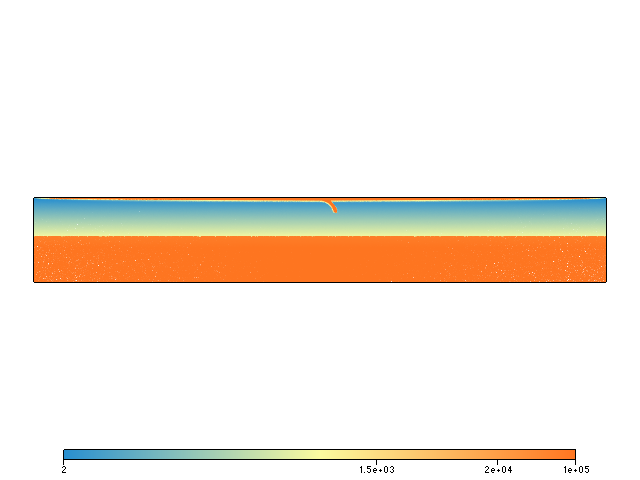

KeyboardInterrupt: 

In [85]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,finalviscosityFn, logScale=True))
#fig.show()
#fig.save_database('test.gldb')

In [ ]:
#fig.save_database('test.gldb')

Stokes system setup
-----


In [59]:
densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StRA,
                                    crustIndex:basaltbuoyancyFn, 
                                    mantleIndex:pyrolitebuoyancyFn,
                                    harzIndex:harzbuoyancyFn} )

In [60]:

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
gravity = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityMapFn * gravity

In [61]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=linearVisc, 
                              fn_bodyforce=buoyancyFn )

In [90]:
solver = uw.systems.Solver(stokesPIC)
if not checkpointLoad:
    solver.solve() #A solve on the linear visocisty is unhelpful unless we're starting from scratch

In [91]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,materialVariable))
#fig.append( glucifer.objects.Surface(mesh, finalviscosityFn, logScale=True))

#fig.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant/ndp.SR, logScale=True))
#fig.show()
#fig.save_database('test.gldb')

In [92]:
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {crustIndex:finalcrustviscosityFn,
                                    mantleIndex:finalviscosityFn,
                                    harzIndex:finalviscosityFn} )



import matplotlib.pylab as pyplt
%matplotlib inline



##################
#Output functions to numpy vertical averages, maxes, mins
##################

viscmapFnmesh = uw.mesh.MeshVariable(mesh,nodeDofCount=1)
out = uw.utils.MeshVariable_Projection( viscmapFnmesh, viscosityMapFn)
out.solve()


#avDf = ndfp.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).mean(axis=1)
avDs = ndsp.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).mean(axis=1)
umantle = mantleviscosityFn.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).mean(axis=1)
lmantle = lowermantleviscosityFn.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).mean(axis=1)
eff = viscmapFnmesh.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).mean(axis=1)

effMin = viscmapFnmesh.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).min(axis=1)
effMax = viscmapFnmesh.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).max(axis=1)

###################
#Plot
###################
import matplotlib.pylab as pyplt
%matplotlib inline

fig, ax = pyplt.subplots()
#ax .plot(avDf, label = 'diff')
#ax .plot(avDs, label = 'dis')
ax .plot(eff, label = 'eff')
ax .plot(effMax, label = 'effMax')
ax .plot(effMin, label = 'effMin')
#ax .plot(umantle, label = 'uman')
#ax .plot(lmantle, label = 'lman')
ax.set_yscale("log", nonposy='clip')
ax.legend(loc = 3)

In [65]:
#Add the non-linear viscosity to the Stokes system
stokesPIC.fn_viscosity = viscosityMapFn

In [66]:
solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4
solver.solve(nonLinearIterate=True)
solver.print_stats()


 
Pressure iterations:   3
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 7.6218e-01
Pressure solve time: 7.0327e-02
Velocity solve time: 7.4009e-01 (backsolve)
Total solve time   : 1.6969e+00
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



In [67]:
#Check which particles are yielding
#yieldingCheck.data[:] = 0

#yieldconditions = [ ( mantleviscosityFn < Visc , 1), 
#               ( True                                           , 0) ]

# use the branching conditional function to set each particle's index
#yieldingCheck.data[:] = fn.branching.conditional( yieldconditions ).evaluate(gSwarm)

In [68]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,yieldingCheck))

#fig.append( glucifer.objects.Surface(mesh,ndflm, logScale=True))
#fig.show()

Advection-diffusion System setup
-----

In [295]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 0.0,
                                         fn_diffusivity = 1.0, 
                                         #conditions     = [neumannTempBC, dirichTempBC] )
                                         conditions     = [ dirichTempBC] )

materialadvector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

In [296]:
#I was playing around with a tailored diffusivity to target the slab

#inCircleFnGenerator#Now build the perturbation part
#def htan(centre, radius, widthPh, farVal = 0.01, fac = 10.):
#    coord = fn.input()
#    offsetFn = coord - centre
#    dist = fn.math.sqrt(fn.math.dot( offsetFn, offsetFn ))
    
    
#    return (((fn.math.tanh(((radius - dist))/widthPh) + 1.) /2.))*fac + farVal

#tfun = htan((0.1, 0.9), 0.1, 0.1, 0.1)

In [207]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TBP
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP

In [208]:
velocityField.data.max()

214.26003226435839

In [209]:
############
#Slightly Diffuse the initial perturbation
#############

timetoDifffuse = 0.#Million years
incrementtoDiffuse = 0.2 #Million years

timetoDifffuse = (timetoDifffuse*1e6*(spery)/sf.SR).magnitude
incrementtoDiffuse = (incrementtoDiffuse*1e6*(spery)/sf.SR).magnitude

totAdt = 0.
it = 0
while totAdt < timetoDifffuse:
    dtad = advDiff.get_max_dt()
    print("step") + str(it) 
    advDiff.integrate(incrementtoDiffuse)
    totAdt += incrementtoDiffuse
    it += 1
    
#Reset Boundary conds.   
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TBP
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP
    
comm.Barrier()

In [210]:
population_control = uw.swarm.PopulationControl(gSwarm,deleteThreshold=0.2,splitThreshold=1.,maxDeletions=3,maxSplits=0, aggressive=True, particlesPerCell=ppc)

Analysis functions / routines
-----

In [211]:
#These are functions we can use to evuate integrals over restricted parts of the domain
# For instance, we can exclude the thermal lithosphere from integrals

def temprestrictionFn(lithval = 0.9):

    tempMM = fn.view.min_max(temperatureField)
    tempMM.evaluate(mesh)
    TMAX = tempMM.max_global()
    mantleconditions = [ (                                  temperatureField > lithval*TMAX, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(mantleconditions)

mantlerestrictFn = temprestrictionFn(lithval = 0.85)



def platenessFn(val = 0.1):
    normgradV = fn.math.abs(velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])) #[du*/dx]/sqrt(u*u)



    srconditions = [ (                                  normgradV < val, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(srconditions)

srrestrictFn = platenessFn(val = 0.1)

In [212]:
#Setup volume integrals 

tempint = uw.utils.Integral( temperatureField, mesh )
areaint = uw.utils.Integral( 1.,               mesh )

v2int   = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )

dwint   = uw.utils.Integral( temperatureField*velocityField[1], mesh )

sinner = fn.math.dot( strainRate_2ndInvariant, strainRate_2ndInvariant )
vdint = uw.utils.Integral( (2.*viscosityMapFn*sinner), mesh ) #Is it two or four here?

mantleArea   = uw.utils.Integral( mantlerestrictFn, mesh )
mantleTemp = uw.utils.Integral( temperatureField*mantlerestrictFn, mesh )
mantleVisc = uw.utils.Integral( mantleviscosityFn*mantlerestrictFn, mesh )
mantleVd = uw.utils.Integral( (2.*viscosityMapFn*sinner*mantlerestrictFn), mesh ) #these now work on MappingFunctions

In [213]:
#Setup surface integrals

rmsSurfInt = uw.utils.Integral( fn=velocityField[0]*velocityField[0], mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuTop      = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuBottom   = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

plateint  = uw.utils.Integral( fn=srrestrictFn, mesh=mesh, integrationType='Surface', #Integrate the plateness function
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"]) 

surfint  = uw.utils.Integral( fn=1., mesh=mesh, integrationType='Surface',   #Surface length function (i.e. domain width)
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

In [214]:
#Define functions for the evaluation of integrals

def basic_int(ourIntegral):           #This one just hands back the evaluated integral
    return ourIntegral.evaluate()[0]

def avg_temp():
    return tempint.evaluate()[0]/areaint.evaluate()[0]

def nusseltTB(temp_field, mesh):
    return -nuTop.evaluate()[0], -nuBottom.evaluate()[0]

def rms():
    return math.sqrt(v2int.evaluate()[0]/areaint.evaluate()[0])

def rms_surf():
    return math.sqrt(rmsSurfInt.evaluate()[0])

def max_vx_surf(velfield, mesh):
    vuvelxfn = fn.view.min_max(velfield[0])
    vuvelxfn.evaluate(mesh.specialSets["MaxJ_VertexSet"])
    return vuvelxfn.max_global()


def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(mesh)
    return vuviscfn.max_global(), vuviscfn.min_global()

In [215]:
#v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=fn.math.dot( velocityField, velocityField ) )
#volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )
#Vrms = math.sqrt( v2sum_integral.evaluate()[0] )/volume_integral.evaluate()[0]



#if(uw.rank()==0):
#    print('Initial Vrms = {0:.3f}'.format(Vrms))

# Check the Metrics

#Avg_temp = avg_temp()
Rms = rms()
Rms_surf = rms_surf()
Max_vx_surf = max_vx_surf(velocityField, mesh)
Rms, Rms_surf, Max_vx_surf 
#Gravwork = basic_int(dwint)
#Viscdis = basic_int(vdint)
#nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
#etamax, etamin = visc_extr(mantleviscosityFn)

#Area_mantle = basic_int(mantleArea)
#Viscmantle = basic_int(mantleVisc)
#Tempmantle = basic_int(mantleTemp)
#Viscdismantle = basic_int(mantleVd)

(32.97548879607268, 192.40476307108926, 161.3107452134814)

Viz.
-----

In [219]:
if figures == 'gldb':
    #Pack some stuff into a database as well
    figDb = glucifer.Figure()
    #figDb.append( glucifer.objects.Mesh(mesh))
    figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.00005))
    #figDb.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
    #figDb.append( glucifer.objects.Points(gSwarm,materialVariable))
    #figDb.append( glucifer.objects.Points(gSwarm,viscMinVariable))
    figDb.append( glucifer.objects.Points(gSwarm,fnViscMin))
    figDb.append( glucifer.objects.Points(gSwarm,viscosityMapFn, logScale=True, valueRange =[1e-3,1e5]))
    #figDb.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True))
    figDb.append( glucifer.objects.Points(gSwarm,temperatureField))

elif figures == 'store':
    fullpath = os.path.join(outputPath + "gldbs/")
    if checkpointLoad:
        store = glucifer.Store(fullpath + 'subduction.gldb')
    else:
        store = glucifer.Store(fullpath + 'subduction')
    

    #figTemp = glucifer.Figure(store,figsize=(300*np.round(aspectRatio,2),300))
    #figTemp.append( glucifer.objects.Points(gSwarm,temperatureField))

    figVisc= glucifer.Figure(store, figsize=(300*np.round(aspectRatio,2),300))
    figVisc.append( glucifer.objects.Points(gSwarm,viscosityMapFn, logScale=True, valueRange =[1e-3,1e5]))

    figMech= glucifer.Figure(store, figsize=(300*np.round(aspectRatio,2),300))
    figMech.append( glucifer.objects.Points(gSwarm,fnViscMin))

**Miscellania**

In [ ]:
##############
#Create a numpy array at the surface to get surface information on (using parallel-friendly evaluate_global)
##############

surface_xs = np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0] + 1)
surface_nodes = np.array(zip(surface_xs, np.ones(len(surface_xs)*mesh.maxCoord[1]))) #For evaluation surface velocity
normgradV = velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])

tempMM = fn.view.min_max(temperatureField)
dummy = tempMM.evaluate(mesh)



In [89]:
##Coordinates for a swarm in the centre of the slab

szLoc = 0.0 #put this up in slab setup section
introPoint = MINX + 0.3
midSwarmDepth = 30.e3/dp.LS
swarmCoords =np.zeros((2000, 2))

reducedRocM = RocM  - midSwarmDepth
xlimslab = reducedRocM*math.cos(math.pi*(90. - theta)/180)
swarmCoords[:, 0] = np.linspace(introPoint, szLoc + xlimslab, 2000) #note SZ location is hardcoded here 
for index, xval in np.ndenumerate(swarmCoords[:,0]):
    #print index, xval
    #swarmCoords[index[0], 1] = 1. - isodepthFn.evaluate((xval, 0.)) #This bit for the plate 
    if  xval < 0.:
        swarmCoords[index[0], 1] = 1. - midSwarmDepth #This bit for the plate 
        
    else:
        swarmCoords[index[0], 1] = (1. - (midSwarmDepth) - (reducedRocM - ( math.sqrt((reducedRocM**2 - xval**2)))))
        
    
swarmCoords = swarmCoords[swarmCoords[:,1] > (1. - maxDepth)] #kill any deeper than cutoff



# initialise a mid-slab swarm to track geometry and a small swarm at the slab tip
midSwarm = uw.swarm.Swarm( mesh=mesh )
tipSwarm = uw.swarm.Swarm( mesh=mesh )

midSwarm.add_particles_with_coordinates(swarmCoords)
tipSwarm.add_particles_with_coordinates(swarmCoords[swarmCoords[:,1] < (1. - (maxDepth - 40e3/dp.LS))])

passiveadvector2 = uw.systems.SwarmAdvector( swarm         = midSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

passiveadvector3 = uw.systems.SwarmAdvector( swarm         = tipSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

tipVar = uw.swarm.SwarmVariable(tipSwarm, dataType='double', count=4)
tipVar.data[:,:2] = velocityField.evaluate(tipSwarm)
tipVar.data[:,2:] = xFn.evaluate(tipSwarm)
tipVar.data[:,3:] = yFn.evaluate(tipSwarm)

In [90]:
#Not parallel friendly yet
#tipXvels = np.sum(velocityField[0].evaluate(tipSwarm)) /\
#    tipSwarm.particleGlobalCount
#tipXvels = np.sum(velocityField[1].evaluate(tipSwarm)) /\
#    tipSwarm.particleGlobalCount
    
#tipXpos = np.sum(xFn.evaluate(tipSwarm)) /\
#    tipSwarm.particleGlobalCount
#tipYpos = np.sum(yFn.evaluate(tipSwarm)) /\
#    tipSwarm.particleGlobalCount

In [37]:
##############
#These functions handle checkpointing
##############

#One limitation is that the Metrics have to exist...this means that these need to be computed first. 
#Sometimes, I forget and the whole thing breaks. Fix when this is put in Slippy

def checkpoint1(step, checkpointPath,filename, filewrites):
    path = checkpointPath + str(step) 
    os.mkdir(path)
    ##Write and save the file, if not already a writing step
    if not step % filewrites == 0:
        filename.write((17*'%-15s ' + '\n') % (realtime, Viscdis, float(nu0), float(nu1), Avg_temp,
                                              Tempmantle,TMAX,
                                              Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin, 
                                              Area_mantle, Viscmantle,  Viscdismantle,Plateness))
    filename.close()
    shutil.copyfile(os.path.join(outputPath, outputFile), os.path.join(path, outputFile))


def checkpoint2(step, checkpointPath, swarm, filename, varlist = [materialVariable], varnames = ['materialVariable']):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    temperatureField.save(os.path.join(path, tempfile))
    pressureField.save(os.path.join(path, pressfile))
    swarm.save(os.path.join(path, "swarm.h5") ) 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.save(os.path.join(path,varnames[ix] + ".h5"))
    

NameError: name 'materialVariable' is not defined

In [ ]:
##############
#This will allow us to evaluate viscous shear heating, and add the result directly to the temperature field
##############

viscDisMapFn = 2.*viscosityMapFn*sinner
viscDisFnmesh = uw.mesh.MeshVariable(mesh,nodeDofCount=1)
viscDisProj = uw.utils.MeshVariable_Projection( viscDisFnmesh, viscDisMapFn)
viscDisProj.solve()

In [ ]:
# initialise timer for computation
start = time.clock()
# setup summary output file (name above)
if checkpointLoad:
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    if len(prevdata.shape) == 1: #this is in case there is only one line in previous file
        realtime = prevdata[0]
    else:
        realtime = prevdata[prevdata.shape[0]-1, 0]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

Main simulation loop
-----


array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [ ]:
#while step < 21:
while realtime < 1.:

    # solve Stokes and advection systems
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    materialadvector.integrate(dt)
    passiveadvector2.integrate(dt)
    passiveadvector3.integrate(dt)
    
    #Add the adiabatic adjustment if in extended boussinesq model:
    if eba:
        temperatureField.data[:] += dt*abHeatFn.evaluate(mesh)
    
        #Add the viscous heating term
         #Need to fix this (forgot 'dissipation number')
        #viscDisProj = uw.utils.MeshVariable_Projection( viscDisFnmesh, viscDisMapFn)
        #viscDisProj.solve()
        #temperatureField.data[:] += dt*viscDisFnmesh.evaluate(mesh)
    

    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    ################
    #Update temperature field in the air region
    #Do this better...
    ################
    if (step % sticky_air_temp == 0):
        for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = ndp.TSP

    # Calculate the Metrics, only on 1 of the processors:
    ################
    if (step % metric_output == 0):
        ###############
        #Swarm - based Metrics
        ###############
        # Calculate the RMS velocity and Nusselt number.
        # Calculate the Metrics, only on 1 of the processors:
        mantlerestrictFn = temprestrictionFn() #rebuild the mantle restriction function (but these should be dynamic?)
        srrestrictFn = platenessFn(val = 0.1) #rebuild the plateness restriction function
        dummy = tempMM.evaluate(mesh) #Re-evaluate any fn.view.min_max guys
        #Rebuild these integrals (a test because metrics changes after a restart)
        mantleArea   = uw.utils.Integral( mantlerestrictFn, mesh )
        mantleTemp = uw.utils.Integral( temperatureField*mantlerestrictFn, mesh )
        mantleVisc = uw.utils.Integral( mantleviscosityFn*mantlerestrictFn, mesh )
        mantleVd = uw.utils.Integral( (4.*viscosityMapFn*sinner*mantlerestrictFn), mesh ) #these now work on MappingFunctions
        ###
        Avg_temp = avg_temp()
        Rms = rms()
        Rms_surf = rms_surf()
        Max_vx_surf = max_vx_surf(velocityField, mesh)
        Gravwork = basic_int(dwint)
        Viscdis = basic_int(vdint)
        nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
        etamax, etamin = visc_extr(mantleviscosityFn)
        Area_mantle = basic_int(mantleArea)
        Viscmantle = basic_int(mantleVisc)
        Tempmantle = basic_int(mantleTemp)
        Viscdismantle = basic_int(mantleVd)
        Plateness = basic_int(plateint)/basic_int(surfint)
        TMAX = tempMM.max_global()
        # output to summary text file
        if uw.rank()==0:
            f_o.write((17*'%-15s ' + '\n') % (realtime, Viscdis, float(nu0), float(nu1), Avg_temp,
                                              Tempmantle,TMAX,
                                              Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin, 
                                              Area_mantle, Viscmantle,  Viscdismantle,Plateness))
    ################
    #Also repopulate entire swarm periodically
    ################
    #if step % swarm_repop == 0:
    population_control.repopulate()   
    ################
    #Checkpoint
    ################
    if step % checkpoint_every == 0:
        if uw.rank() == 0:
            checkpoint1(step, checkpointPath,f_o, metric_output)           
        checkpoint2(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
        f_o = open(os.path.join(outputPath, outputFile), 'a') #is this line supposed to be here?
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0): 
        if figures == 'gldb':
            #Remember to rebuild any necessary swarm variables
            fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
            fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
            figDb.save_database(fullpath)
        elif figures == 'store':      
            fullpath = os.path.join(outputPath + "images/") #in Bec's example pngs get automatically written in fig.Save stor is also uodated
            store.step = step
            #Save figures to store
            figVisc.save( fullpath + "Visc" + str(step).zfill(4))
            figMech.save( fullpath + "Mech" + str(step).zfill(4))
            #figTemp.save(    outputPath + "Temp"    + str(step).zfill(4))
    ################
    #Files output
    ################ 
    if (step % files_output == 0):

        vel_surface = velocityField.evaluate_global(surface_nodes)
        norm_surface_sr = normgradV.evaluate_global(surface_nodes)
        if uw.rank() == 0:
            fnametemp = "velsurface" + "_" + str(ModIt) + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, vel_surface)
            fnametemp = "norm_surface_sr" + "_" + str(ModIt) + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, norm_surface_sr)
        #Save the midswarm and tipswarm coords 
        fnametemp1 = "midSwarm" + "_" + str(ModIt) + "_" + str(step)
        fullpath1 = os.path.join(outputPath + "files/" + fnametemp1)
        midSwarm.save(fullpath1)
        tipVar.data[:,:2] = velocityField.evaluate(tipSwarm)
        tipVar.data[:,2:] = xFn.evaluate(tipSwarm)
        tipVar.data[:,3:] = yFn.evaluate(tipSwarm)
        #fnametemp2 = "tipSwarm" + "_" + str(ModIt) + "_" + str(step)
        #fullpath2 = os.path.join(outputPath + "files/" + fnametemp2)
        #tipSwarm.save(fullpath2)
        
    ################
    #Particle update
    ###############    
    #ageVariable.data[:] += dt #increment the ages (is this efficient?)
    ageDT += dt
    
    if step % swarm_update == 0:
        #Increment age stuff. 
        ageConditions = [ (depthFn < AGETRACKDEPTH, ageVariable + ageDT ),  #add ageDThere
                  (True, 0.) ]
        ageVariable.data[:] = fn.branching.conditional( ageConditions ).evaluate(gSwarm)        
        ageDT = 0. #reset the age incrementer
        
        #Apply any materialVariable changes
        for i in range(2): #go through twice
            materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

    
f_o.close()
print 'step =',step

In [ ]:
#viscVariable = gSwarm.add_variable( dataType="float", count=1 )
#viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)

#buoyVariable = gSwarm.add_variable( dataType="float", count=1 )
#buoyVariable.data[:] = densityMapFn.evaluate(gSwarm)

In [ ]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,ageVariable))
#fig.append( glucifer.objects.Points(gSwarm, viscosityMapFn, logScale=True, valueRange =[1e-3,1e5]))

#fig.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True, valueRange =[1e-3,1e5] ))
#fig.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.002))
#fig.append( glucifer.objects.Surface(mesh,densityMapFn))
#fig.append( glucifer.objects.Surface(mesh,raylieghFn))

#fig.show()
#fig.save_database('test.gldb')

In [300]:
velocityField.data[tWalls.data].max()

239.75242232894851

In [301]:
velocityField.data.max()

325.43795809700674

In [ ]:
testFn  = fn.branching.conditional([(depthFn < MANTLETOCRUST*3, 2.),
                                                     (interfaceCond, 1.), #
                                                     (True, 0.)])

In [24]:
ndp.Wdf, ndp.Edf

(44.437143733652142, 27.756703243833382)

In [87]:
step = 2
fnametemp = "midSwarm" + "_" + str(ModIt) + "_" + str(step)
fullpath = os.path.join(outputPath + "files/" + fnametemp)
fullpath

'results/T/0/Base/files/midSwarm_Base_2'

In [91]:
fnametemp = "midSwarm" + "_" + str(ModIt) + "_" + str(step)
fullpath = os.path.join(outputPath + "files/" + fnametemp)
midSwarm.save(fullpath)

fnametemp = "tipSwarm" + "_" + str(ModIt) + "_" + str(step)
fullpath = os.path.join(outputPath + "files/" + fnametemp)
tipSwarm.save(fullpath)